<a href="https://colab.research.google.com/github/Jonathan-Chia/mmm-research/blob/main/bayesian_mmm_causal_issues.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian MMM - causal marketing impacts

Most causal MMM literature focuses on using DAGs to decide which control variables to include, but rarely on the causal links between marketing channels themselves—they are typically assumed independent. With well-chosen priors, especially from previous lift experiments, models should still generally identify which channels are most effective.

In this notebook, we explore a scenario where display ads strongly influence paid search. We ask: if we assume channels are independent, how biased are our estimates? And can incorporating prior lift experiment data help reduce this bias?

Our marketing channels have this causal dag:

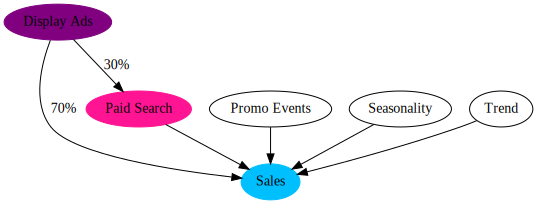

In [ ]:
import graphviz as gr

g = gr.Digraph()
g.node(name="Sales", label="Sales", color="deepskyblue", style="filled")
g.node(name='Display Ads', label='Display Ads', color='purple', style='filled')
g.node(name="Paid Search", label="Paid Search", color="deeppink", style="filled")
g.edge(tail_name="Display Ads", head_name="Paid Search", label='30%')
g.edge(tail_name="Display Ads", head_name="Sales", label='70%')
g.edge(tail_name="Promo Events", head_name="Sales")
g.edge(tail_name="Paid Search", head_name="Sales")
g.edge(tail_name="Seasonality", head_name="Sales")
g.edge(tail_name="Trend", head_name="Sales")
g

A naive MMM would consider Paid Search and Display Ads as independent channels. Let us simulate a more realistic scenario: 70% of display ads impressions flows directly to sales, while 30% flow to paid search channel.

Our data has total display impressions and total search impressions, with some overlapping impressions. Thus, there are three impacts:

* Display impressions directly affecting sales
* Display impressions leading to search impressions affecting sales
* Direct Search impressions

How we would model this would be as follows:

$$
Sales_t \sim \mathcal{N}(\mu_t, \sigma) \\
$$

$$
\mu_t = \alpha
+ \beta_1 \cdot \text{DisplayDirect}_t
+ \beta_2 \cdot \text{DisplayAndSearch}_t
+ \beta_3 \cdot \text{SearchDirect}_t \\
+ \text{Fourier}_t \cdot \beta_{\text{fourier}}
+ \beta_t \cdot trend
+ \gamma_1 \cdot \text{Event1}_t
+ \gamma_2 \cdot \text{Event2}_t \\
$$

Where, on top of finding the $\beta$ coefficients, we alsowant to uncover the true proportion of display ads flowing into search:

$$
\pi \sim \text{Beta}(2, 2) \\
$$

$$
\text{DisplayAndSearch}_t = \pi \cdot \text{DisplayAds}_t \\
\text{DisplayDirect}_t = (1 - \pi) \cdot \text{TotalDisplayAds}_t \\
\text{SearchDirect}_t = \text{TotalPaidSearch}_t - \text{DisplayAndSearch}_t \\
$$


with these other priors:

$$
\alpha \sim \mathcal{N}(0.5, 0.2) \\
\beta_t \sim \text{HalfNormal}(0.02) \\
\beta_{\text{fourier}} \sim \text{Laplace}(0, 0.2) \\
\gamma_1, \gamma_2 \sim \mathcal{N}(0, 0.05) \\
\beta_{\text{disp,dir}}, \beta_{\text{disp,search}}, \beta_{\text{search,dir}} \sim \text{HalfNormal}(0.5) \\
\sigma \sim \text{HalfNormal}(2)
$$

We will add some uncertainty to the $\text{DisplayAndSearch}_t$ by modeling it as a normal distribution and adding a search $\sigma$.

In [ ]:
!pip install pymc_marketing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.4/252.4 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 9.2 MB/s eta 0:00:00


In [ ]:
from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.transformers import geometric_adstock, michaelis_menten
import pandas as pd
import preliz as pz
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import xarray as xr

## Generate Data

First generate the dates.

In [ ]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

# date range
min_date = pd.to_datetime("2018-04-01")
max_date = pd.to_datetime("2021-09-01")

df = pd.DataFrame(
    data={"date_week": pd.date_range(start=min_date, end=max_date, freq="W-MON")}
).assign(
    year=lambda x: x["date_week"].dt.year,
    month=lambda x: x["date_week"].dt.month,
    dayofyear=lambda x: x["date_week"].dt.dayofyear,
)

n = df.shape[0]
print(f"Number of observations: {n}")

Number of observations: 179


Generate media channel data. Notice that we spend more in display ads.

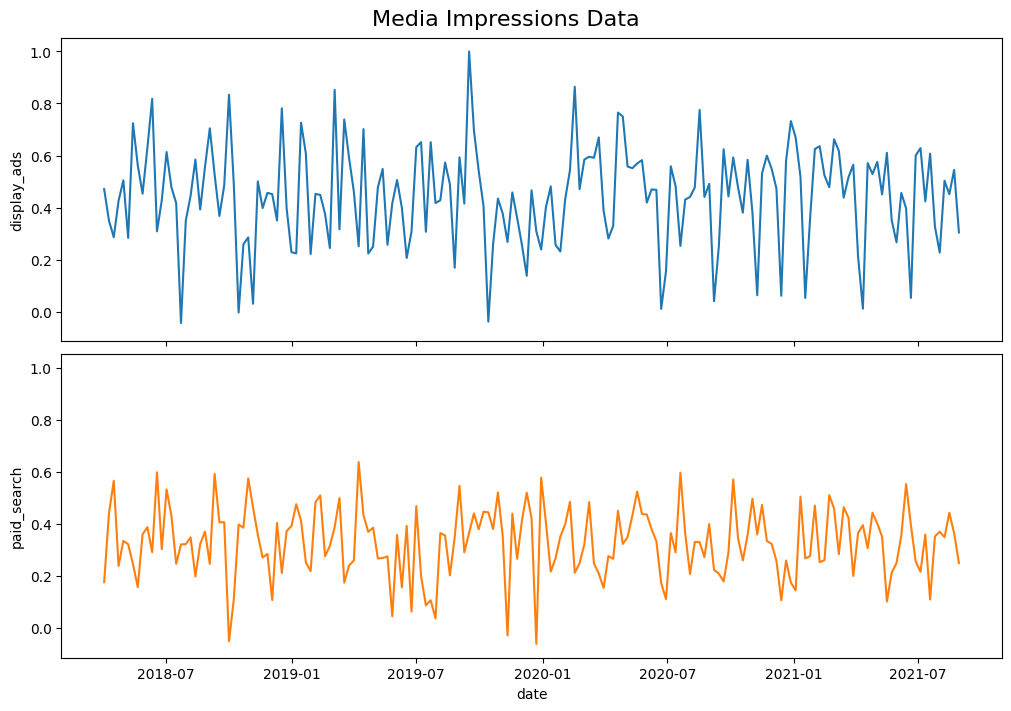

In [ ]:
# media data
display_ads = pz.Normal(mu=100000, sigma=40000).rvs(n, random_state=rng)
df['display_ads'] = np.where(display_ads > 30000, display_ads, display_ads / 2)


df["paid_search"] = pz.Normal(mu=70000, sigma=30000).rvs(n, random_state=rng)

max_display = df["display_ads"].max()

# Scale both channels by display max
df["display_ads"] = df["display_ads"] / max_display
df["paid_search"] = df["paid_search"] / max_display

fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 7), sharex=True, sharey=True, layout="constrained"
)
sns.lineplot(x="date_week", y="display_ads", data=df, color="C0", ax=ax[0])
sns.lineplot(x="date_week", y="paid_search", data=df, color="C1", ax=ax[1])
ax[1].set(xlabel="date")
fig.suptitle("Media Impressions Data", fontsize=16);

In [ ]:
# apply geometric adstock transformation
alpha1: float = 0.6
alpha2: float = 0.2

df["display_ads_adstock"] = (
    geometric_adstock(x=df["display_ads"].to_numpy(), alpha=alpha1, l_max=24, normalize=True)
    .eval()
    .flatten()
)

df["paid_search_adstock"] = (
    geometric_adstock(x=df["paid_search"].to_numpy(), alpha=alpha2, l_max=24, normalize=True)
    .eval()
    .flatten()
)

In [ ]:
from pymc_marketing.mmm.transformers import logistic_saturation
# apply saturation transformation
# Find the median adstocked value
x_median_display = np.median(df['display_ads_adstock'])
x_median_search = np.median(df['paid_search_adstock'])

# Choose λ so f(x_median) ≈ 0.5 (midpoint of saturation)
lam1 = 4
lam2 = 4


# lam1: float = np.median(df['display_ads_adstock'])
# lam2: float = np.median(df['paid_search_adstock'])

# alpha_mm1: float = 6
# alpha_mm2: float = 12

df["display_ads_adstock_saturated"] = logistic_saturation(
    x=df["display_ads_adstock"].to_numpy(), lam=lam1
).eval()

df["paid_search_adstock_saturated"] = logistic_saturation(
    x=df["paid_search_adstock"].to_numpy(), lam=lam2
).eval()

# df["display_ads_adstock_saturated"] = michaelis_menten(
#     x=df["display_ads_adstock"].to_numpy(), lam=lam1, alpha=alpha_mm1
# )

# df["paid_search_adstock_saturated"] = michaelis_menten(
#     x=df["paid_search_adstock"].to_numpy(), lam=lam2, alpha=alpha_mm2
# )

Here's the transformed media spend.

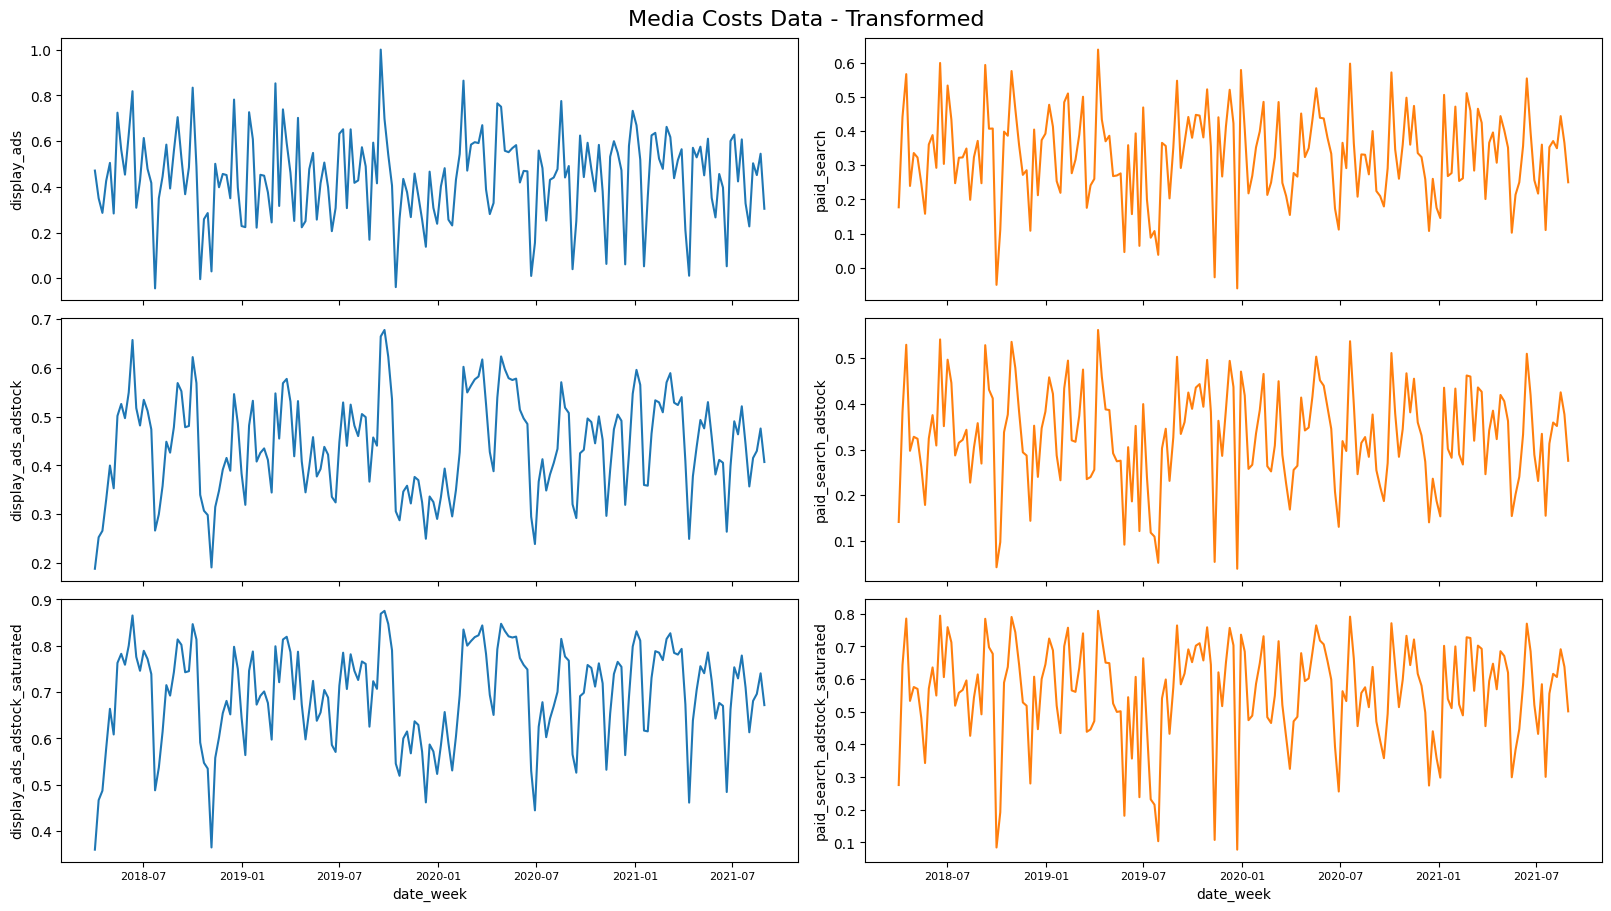

In [ ]:
fig, ax = plt.subplots(
    nrows=3, ncols=2, figsize=(16, 9), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(x="date_week", y="display_ads", data=df, color="C0", ax=ax[0, 0])
sns.lineplot(x="date_week", y="paid_search", data=df, color="C1", ax=ax[0, 1])
sns.lineplot(x="date_week", y="display_ads_adstock", data=df, color="C0", ax=ax[1, 0])
sns.lineplot(x="date_week", y="paid_search_adstock", data=df, color="C1", ax=ax[1, 1])
sns.lineplot(x="date_week", y="display_ads_adstock_saturated", data=df, color="C0", ax=ax[2, 0])
sns.lineplot(x="date_week", y="paid_search_adstock_saturated", data=df, color="C1", ax=ax[2, 1])
fig.suptitle("Media Costs Data - Transformed", fontsize=16)
# adjust size of X axis
ax[2, 0].tick_params(axis="x", labelsize=8)
ax[2, 1].tick_params(axis="x", labelsize=8);

Also adding in some seasonality and trend.

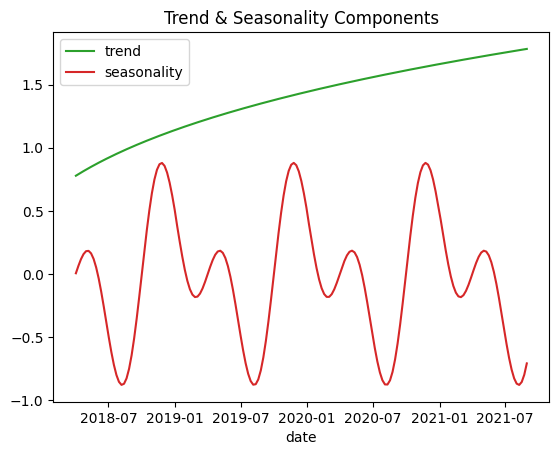

In [ ]:
# add seasonality and trend
df["trend"] = (np.linspace(start=0.0, stop=50, num=n) + 10) ** (1 / 4) - 1

df["cs"] = -np.sin(2 * 2 * np.pi * df["dayofyear"] / 365.5)
df["cc"] = np.cos(1 * 2 * np.pi * df["dayofyear"] / 365.5)
df["seasonality"] = 0.5 * (df["cs"] + df["cc"])

fig, ax = plt.subplots()
sns.lineplot(x="date_week", y="trend", color="C2", label="trend", data=df, ax=ax)
sns.lineplot(
    x="date_week", y="seasonality", color="C3", label="seasonality", data=df, ax=ax
)
ax.legend(loc="upper left")
ax.set(title="Trend & Seasonality Components", xlabel="date", ylabel=None);

Add some promotional events

In [ ]:
# add some promotional events
df["event_1"] = (df["date_week"] == "2019-05-13").astype(float)
df["event_2"] = (df["date_week"] == "2020-09-14").astype(float)

Combine them all together to create our sales. We will choose the parameters for these channels, and then see if the model can recover these true parameters.

Remember:
$$
Sales_t \sim \mathcal{N}(\mu_t, \sigma) \\
$$

$$
\mu_t = \alpha
+ \beta_1 \cdot \text{DisplayDirect}_t
+ \beta_2 \cdot \text{DisplayAndSearch}_t
+ \beta_3 \cdot \text{SearchDirect}_t \\
+ \text{Fourier}_t \cdot \beta_{\text{fourier}}
+ \beta_t \cdot trend
+ \gamma_1 \cdot \text{Event1}_t
+ \gamma_2 \cdot \text{Event2}_t \\
$$

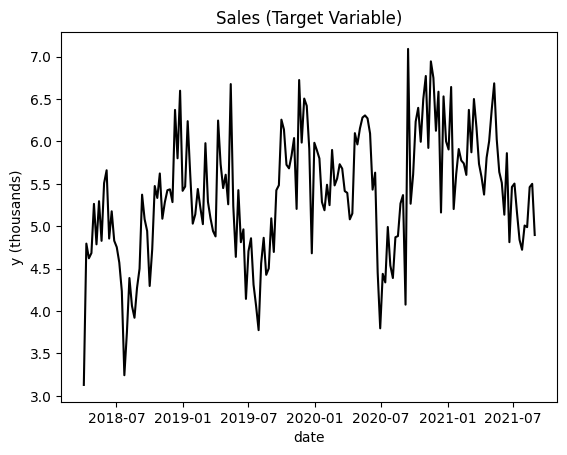

In [ ]:
df["intercept"] = 1
df["epsilon"] = rng.normal(loc=0.0, scale=0.25, size=n)

amplitude = 1
beta_1 = 3.0 # display direct
beta_2 = 4.0 # let's assume that being touched by both display and search increases a customer's chance to convert by a decent amount - keep in mind this costs more too
beta_3 = 2.0 # search direct
betas = [beta_1, beta_2, beta_3]
proportion_display_to_search = 0.30 # 30% of impressions from display are funneled to search

df['display_ads_adstock_saturated_direct'] = df['display_ads_adstock_saturated'] * (1 - proportion_display_to_search)
df['display_search_adstock_saturated'] = df['display_ads_adstock_saturated'] * (proportion_display_to_search)
df['paid_search_adstock_saturated_direct'] = df['paid_search_adstock_saturated'] - df['display_search_adstock_saturated']

df["y"] = amplitude * (
    df["intercept"]
    + beta_1 * df['display_ads_adstock_saturated_direct']
    + beta_2 * df['display_search_adstock_saturated']
    + beta_3 * df['paid_search_adstock_saturated_direct']
    + df["seasonality"]
    + df["trend"]
    + 1.5 * df["event_1"]
    + 2.5 * df["event_2"]
    + df["epsilon"] # this is the sigma
)

fig, ax = plt.subplots()
sns.lineplot(x="date_week", y="y", color="black", data=df, ax=ax)
ax.set(title="Sales (Target Variable)", xlabel="date", ylabel="y (thousands)");

Next let's look at each variable's contribution to our simulated sales.

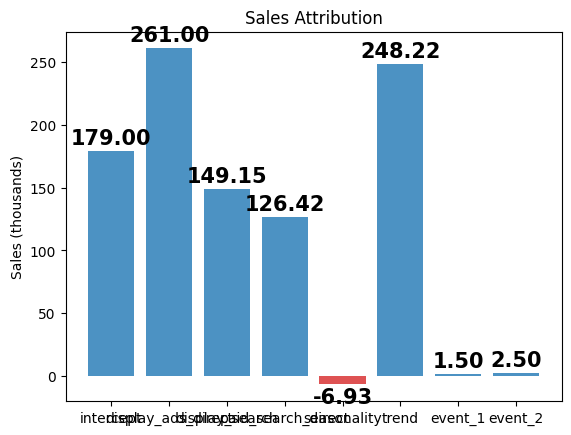

In [ ]:
fig, ax = plt.subplots()

contributions = [
    df["intercept"].sum(),
    (beta_1 * df['display_ads_adstock_saturated_direct']).sum(),
    (beta_2 * df['display_search_adstock_saturated']).sum(),
    (beta_3 * df['paid_search_adstock_saturated_direct']).sum(),
    df["seasonality"].sum(),
    df["trend"].sum(),
    1.5 * df["event_1"].sum(),
    2.5 * df["event_2"].sum(),
]

ax.bar(
    ["intercept", "display_ads_direct", "display_search", "paid_search_direct", "seasonality", "trend", "event_1", "event_2"],
    contributions,
    color=["C0" if x >= 0 else "C3" for x in contributions],
    alpha=0.8,
)
ax.bar_label(
    ax.containers[0],
    fmt="{:,.2f}",
    label_type="edge",
    padding=2,
    fontsize=15,
    fontweight="bold",
)
ax.set(title="Sales Attribution", ylabel="Sales (thousands)");

How about contribution of just the marketing channels?

In [ ]:
contribution_share_display_ads: float = (beta_1 * df["display_ads_adstock_saturated_direct"]).sum() / (
    beta_1 * df["display_ads_adstock_saturated_direct"] + beta_2 * df["display_search_adstock_saturated"] + beta_3 * df["paid_search_adstock_saturated_direct"]
).sum()

contribution_share_display_search: float = (beta_2 * df["display_search_adstock_saturated"]).sum() / (
    beta_1 * df["display_ads_adstock_saturated_direct"] + beta_2 * df["display_search_adstock_saturated"] + beta_3 * df["paid_search_adstock_saturated_direct"]
).sum()

contribution_share_paid_search: float = (beta_3 * df["paid_search_adstock_saturated_direct"]).sum() / (
    beta_1 * df["display_ads_adstock_saturated_direct"] + beta_2 * df["display_search_adstock_saturated"] + beta_3 * df["paid_search_adstock_saturated_direct"]
).sum()

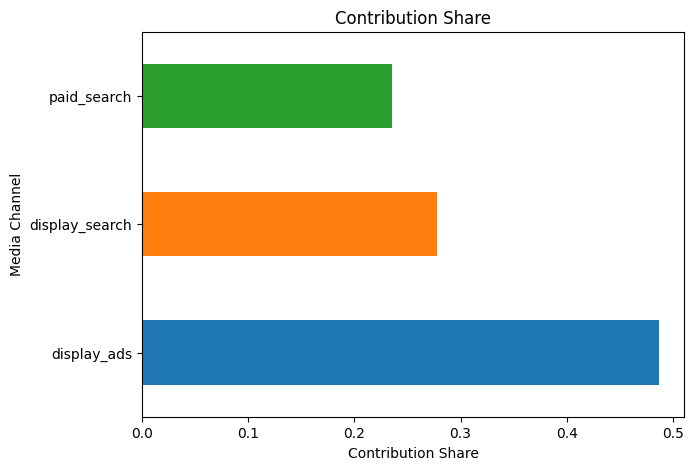

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))

contribution_shares = {
    "display_ads": contribution_share_display_ads,
    "display_search": contribution_share_display_search,
    "paid_search": contribution_share_paid_search,
}

pd.Series(contribution_shares).plot(kind="barh", color=["C0", "C1", "C2"])

ax.set(title="Contribution Share", xlabel="Contribution Share", ylabel="Media Channel");

In [ ]:
# combined display
contribution_share_display_total = (
    contribution_share_display_ads + contribution_share_display_search
)

Now let's look at the actual ROAS from this simulated data.

In [ ]:
roas_1_actual = (amplitude * beta_1 * df["display_ads_adstock_saturated_direct"]).sum() / (df["display_ads"].sum()*(1-proportion_display_to_search))
roas_2_actual = (amplitude * beta_2 * df["display_search_adstock_saturated"]).sum() / (df["display_ads"].sum()*(proportion_display_to_search))
roas_3_actual = (amplitude * beta_3 * df["paid_search_adstock_saturated_direct"]).sum() / (df["paid_search"].sum())

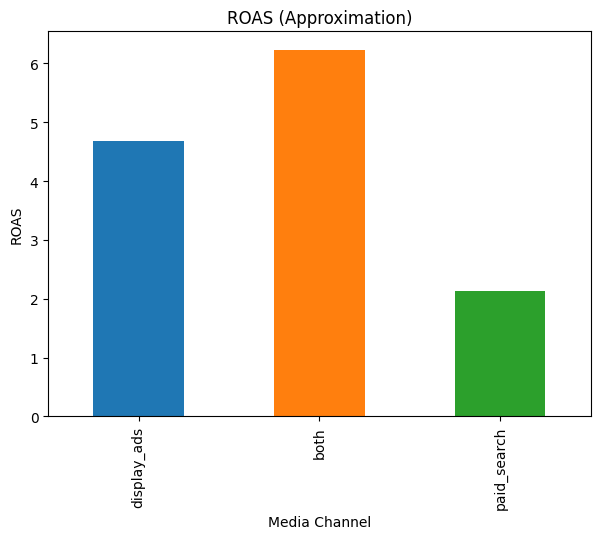

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
(
    pd.Series(data=[roas_1_actual, roas_2_actual, roas_3_actual], index=["display_ads", "both", "paid_search"]).plot(
        kind="bar", color=["C0", "C1", "C2"]
    )
)

ax.set(title="ROAS (Approximation)", xlabel="Media Channel", ylabel="ROAS");

In [ ]:
# weighted average roas for all display
roas_display_total = ((amplitude * beta_1 * df["display_ads_adstock_saturated_direct"]).sum() + (amplitude * beta_2 * df["display_search_adstock_saturated"]).sum()) / (df["display_ads"].sum())

## Data Preprocessing for Model Fitting

Now we have created our simulated data, we will attempt to model this data.

Below we prepare the data to be modeled.

In [ ]:

columns_to_keep = [
    "date_week",
    "y",
    "display_ads",
    "paid_search",
    "event_1",
    "event_2",
    "dayofyear",
]

data = df[columns_to_keep].copy()

data.head()

date_week         y  display_ads  paid_search  event_1  event_2  dayofyear
0 2018-04-02  3.128453     0.470944     0.176949      0.0      0.0         92
1 2018-04-09  4.794769     0.349739     0.441261      0.0      0.0         99
2 2018-04-16  4.621613     0.285909     0.566737      0.0      0.0        106
3 2018-04-23  4.683249     0.425862     0.239445      0.0      0.0        113
4 2018-04-30  5.263275     0.504540     0.335791      0.0      0.0        120

Add trend feature.

In [ ]:
# trend feature
data["t"] = range(n)

data.head()

date_week         y  display_ads  paid_search  event_1  event_2  dayofyear  \
0 2018-04-02  3.128453     0.470944     0.176949      0.0      0.0         92   
1 2018-04-09  4.794769     0.349739     0.441261      0.0      0.0         99   
2 2018-04-16  4.621613     0.285909     0.566737      0.0      0.0        106   
3 2018-04-23  4.683249     0.425862     0.239445      0.0      0.0        113   
4 2018-04-30  5.263275     0.504540     0.335791      0.0      0.0        120   

   t  
0  0  
1  1  
2  2  
3  3  
4  4

Scale data from 0 - 1 (helps with sampling).

In [ ]:
# scale the data
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
scaled_data = data.copy()
scaled_data[['y', 'dayofyear', 't']] = scaler.fit_transform(scaled_data[['y', 'dayofyear', "t"]])

Make seasonality features.

In [ ]:
import numpy as np

def make_fourier_features(dayofyear, period=365.25, order=3):
    """Return sine and cosine Fourier terms up to the given order."""
    x = 2 * np.pi * dayofyear[:, None] / period
    terms = [np.sin(k * x) for k in range(1, order + 1)] + \
            [np.cos(k * x) for k in range(1, order + 1)]
    return np.hstack(terms)

# Example usage
fourier_terms = make_fourier_features(data['dayofyear'].values, order=2)

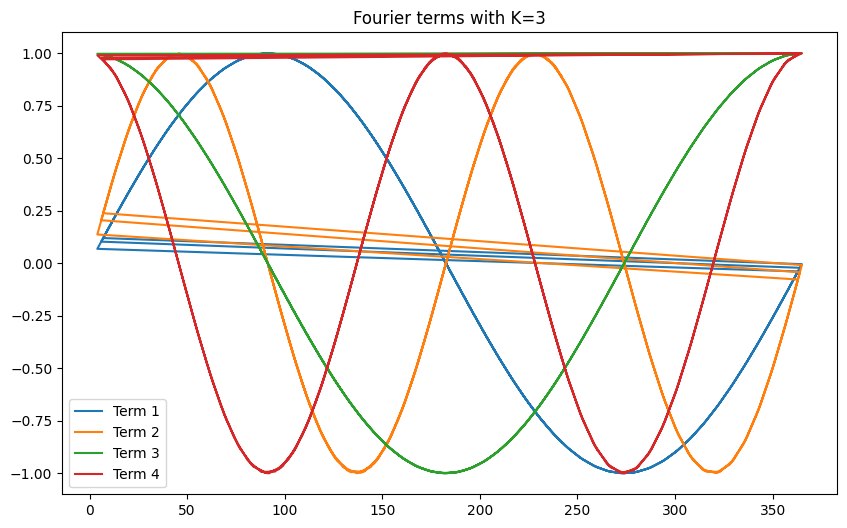

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(fourier_terms.shape[1]):
    ax.plot(data['dayofyear'], fourier_terms[:, i], label=f"Term {i+1}")
ax.legend()
ax.set_title(f"Fourier terms with K={3}")
plt.show()

In [ ]:
# add fourier terms to scaled_data
scaled_data = pd.concat([scaled_data, pd.DataFrame(fourier_terms, columns=[f"fourier_{i}" for i in range(fourier_terms.shape[1])])], axis=1)
scaled_data.head()

date_week         y  display_ads  paid_search  event_1  event_2  dayofyear  \
0 2018-04-02  0.441231     0.470944     0.176949      0.0      0.0   0.252055   
1 2018-04-09  0.676246     0.349739     0.441261      0.0      0.0   0.271233   
2 2018-04-16  0.651824     0.285909     0.566737      0.0      0.0   0.290411   
3 2018-04-23  0.660517     0.425862     0.239445      0.0      0.0   0.309589   
4 2018-04-30  0.742323     0.504540     0.335791      0.0      0.0   0.328767   

          t  fourier_0  fourier_1  fourier_2  fourier_3  
0  0.000000   0.999930  -0.023651  -0.011826  -0.999720  
1  0.005618   0.991269  -0.261414  -0.131859  -0.965227  
2  0.011236   0.968251  -0.484089  -0.249981  -0.875019  
3  0.016854   0.931210  -0.678820  -0.364483  -0.734304  
4  0.022472   0.880683  -0.834370  -0.473706  -0.551205

# Causal Model

In [ ]:
from pymc_marketing.mmm import GeometricAdstock, LogisticSaturation

def forward_pass(x, adstock_alpha, saturation_lam, saturation_beta, l_max=8):
    """
    Forward pass using GeometricAdstock and LogisticSaturation classes
    with PyMC variables.
    """
    # Apply adstock using the class method
    x_adstocked = GeometricAdstock(l_max=l_max).function(x, alpha=adstock_alpha)

    # Apply saturation using the class method
    x_saturated = LogisticSaturation().function(x=x_adstocked, lam=saturation_lam, beta=saturation_beta)

    return x_saturated


We will now build the model based on the following formula and add priors:

$$
Sales_t \sim \mathcal{N}(\mu_t, \sigma) \\
$$

$$
\mu_t = \alpha
+ \beta_1 \cdot \text{DisplayDirect}_t
+ \beta_2 \cdot \text{DisplayAndSearch}_t
+ \beta_3 \cdot \text{SearchDirect}_t \\
+ \text{Fourier}_t \cdot \beta_{\text{fourier}}
+ \beta_t \cdot trend
+ \gamma_1 \cdot \text{Event1}_t
+ \gamma_2 \cdot \text{Event2}_t \\
$$

In [ ]:
import pymc as pm

with pm.Model() as model:
    # ----------------------
    # Data
    # ----------------------
    display_ads = pm.Data("display_ads", scaled_data["display_ads"].values)
    paid_search = pm.Data("paid_search", scaled_data["paid_search"].values)
    t = pm.Data('t', scaled_data["t"].values)
    event_1 = pm.Data('event1', scaled_data["event_1"].values)
    event_2 = pm.Data('event2', scaled_data["event_2"].values)
    y = pm.Data('y', scaled_data['y'].values)
    # ----------------------
    # Priors
    # ----------------------
    alpha = pm.Normal("alpha", 0.5, sigma=0.2)          # intercept
    beta_t = pm.HalfNormal("beta_t", sigma=0.1)        # trend slope
    # Fourier terms
    beta_fourier = pm.Laplace("beta_fourier", mu=0.0, b=0.2, shape=fourier_terms.shape[1])
    # Control events
    gamma_control1 = pm.Normal("gamma_control1", 0, 0.05)
    gamma_control2 = pm.Normal("gamma_control2", 0, 0.05)

    # adstock and saturation
    adstock_alpha1 = pm.Beta("adstock_alpha1", alpha=2, beta=2)
    saturation_lam1 = pm.Gamma("saturation_lam1", alpha=3, beta=1)
    saturation_beta1 = pm.HalfNormal("saturation_beta1", sigma=2)

    adstock_alpha2 = pm.Beta("adstock_alpha2", alpha=2, beta=2)
    saturation_lam2 = pm.Gamma("saturation_lam2", alpha=3, beta=1)
    saturation_beta2 = pm.HalfNormal("saturation_beta2", sigma=2)

    pi = pm.Beta("display_to_search_proportion", alpha=2, beta=2) # wide prior
    display_transformed = forward_pass(display_ads,  adstock_alpha1, saturation_lam1, saturation_beta1)
    search_transformed = forward_pass(paid_search, adstock_alpha2, saturation_lam2, saturation_beta2)

    # Mediator: Display → Search
    mu_ds = pi * display_transformed
    sigma_ds = pm.HalfNormal("sigma_ds", sigma=0.2)
    display_and_search = pm.Normal("display_and_search", mu=mu_ds, sigma=sigma_ds, shape=scaled_data['display_ads'].shape) # display and search is normally distributed with some random noise
    display_direct = display_transformed - display_and_search
    search_direct = search_transformed - display_and_search

    beta_display_direct = pm.HalfNormal("beta_display_direct", sigma=0.5)
    beta_display_and_search = pm.HalfNormal("beta_display_and_search", sigma=0.5)
    beta_search_direct = pm.HalfNormal("beta_search_direct", sigma=0.5)

    # Noise
    sigma = pm.HalfNormal("sigma", sigma=2)

    # combine everything to make mu of y
    display_direct_contribution = pm.Deterministic("display_direct_contribution", beta_display_direct * display_direct)
    display_and_search_contribution = pm.Deterministic("display_and_search_contribution", beta_display_and_search * display_and_search)
    search_direct_contribution = pm.Deterministic("search_direct_contribution", beta_search_direct * search_direct)
    fourier_contribution = pm.Deterministic("fourier_contribution", pm.math.dot(fourier_terms, beta_fourier))
    trend_contribution = pm.Deterministic("trend_contribution", beta_t * t)
    control1_contribution = pm.Deterministic("control1_contribution", gamma_control1 * event_1)
    control2_contribution = pm.Deterministic("control2_contribution", gamma_control2 * event_2)
    spend_display_direct = pm.Data("spend_display_direct", df["display_ads"].sum() * (1 - proportion_display_to_search))
    spend_display_search = pm.Data("spend_display_search", df["display_ads"].sum() * proportion_display_to_search)
    spend_search_direct = pm.Data("spend_search_direct", df["paid_search"].sum())

    contrib_display_direct = pm.Deterministic("contrib_display_direct", beta_display_direct * display_direct.sum())
    contrib_display_search = pm.Deterministic("contrib_display_search", beta_display_and_search * display_and_search.sum())
    contrib_search_direct = pm.Deterministic("contrib_search_direct", beta_search_direct * search_direct.sum())

    roas_1 = pm.Deterministic("roas_display_direct", contrib_display_direct / spend_display_direct)
    roas_2 = pm.Deterministic("roas_display_search", contrib_display_search / spend_display_search)
    roas_3 = pm.Deterministic("roas_search_direct", contrib_search_direct / spend_search_direct)


    mu = pm.Deterministic(
        "mu",
        alpha
        + display_direct_contribution
        + display_and_search_contribution
        + search_direct_contribution
        + fourier_contribution
        + trend_contribution
        + control1_contribution
        + control2_contribution
    )

    # Likelihood
    Ylikelihood = pm.Normal("Ylikelihood", mu, sigma, observed=y)

    # Prior predictive check
    idata = pm.sample_prior_predictive(samples=500, random_seed=rng)

Check if we chose good priors.

Shape of y_prior before squeeze: (1, 500, 179)
Shape of y_prior after squeeze: (500, 179)


/tmp/ipython-input-4071725776.py:9: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_94 = az.hdi(y_prior_squeezed, hdi_prob=0.94)
/tmp/ipython-input-4071725776.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_50 = az.hdi(y_prior_squeezed, hdi_prob=0.50)


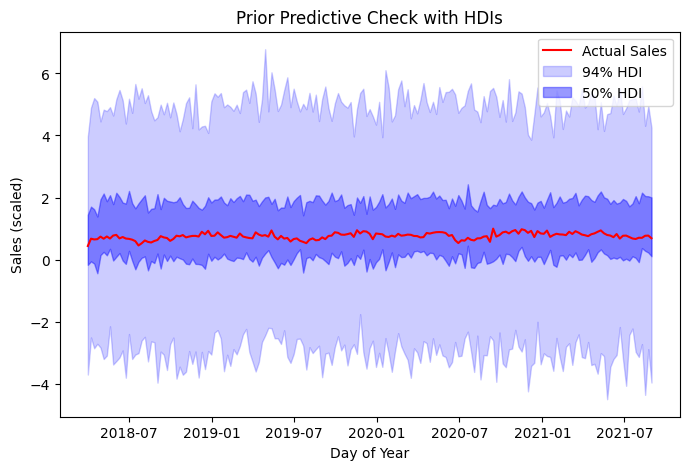

In [ ]:
# Extract predictions
y_prior = idata.prior_predictive["Ylikelihood"].values
print(f"Shape of y_prior before squeeze: {y_prior.shape}")

# Remove the extra dimension of size 1
y_prior_squeezed = np.squeeze(y_prior)
print(f"Shape of y_prior after squeeze: {y_prior_squeezed.shape}")

hdi_94 = az.hdi(y_prior_squeezed, hdi_prob=0.94)
hdi_50 = az.hdi(y_prior_squeezed, hdi_prob=0.50)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(scaled_data['date_week'].values, scaled_data['y'], color="red", label="Actual Sales")
plt.fill_between(scaled_data['date_week'].values, hdi_94[:, 0], hdi_94[:, 1], color="blue", alpha=0.2, label="94% HDI")
plt.fill_between(scaled_data['date_week'].values, hdi_50[:, 0], hdi_50[:, 1], color="blue", alpha=0.4, label="50% HDI")
plt.title("Prior Predictive Check with HDIs")
plt.xlabel("Day of Year")
plt.ylabel("Sales (scaled)")
plt.legend()
plt.show()

## Model Diagnostics

In [ ]:
with model:
    idata.extend(pm.sample(
        draws=1000,           # posterior draws per chain
        tune=1000,            # tuning/adaptation steps
        chains=4,
        cores=4,
        target_accept=0.95,   # higher to reduce divergences
        max_treedepth=15,     # increase if you see warnings about treedepth
        init="adapt_diag",    # good default init
        random_seed=rng
    ))

az.plot_trace(idata);

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

# # Save to Drive
az.to_netcdf(idata, "/content/drive/MyDrive/my_model_results.nc")

# Load back
idata = az.from_netcdf("/content/drive/MyDrive/my_model_results.nc")

In [ ]:
with model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=rng)

Output()

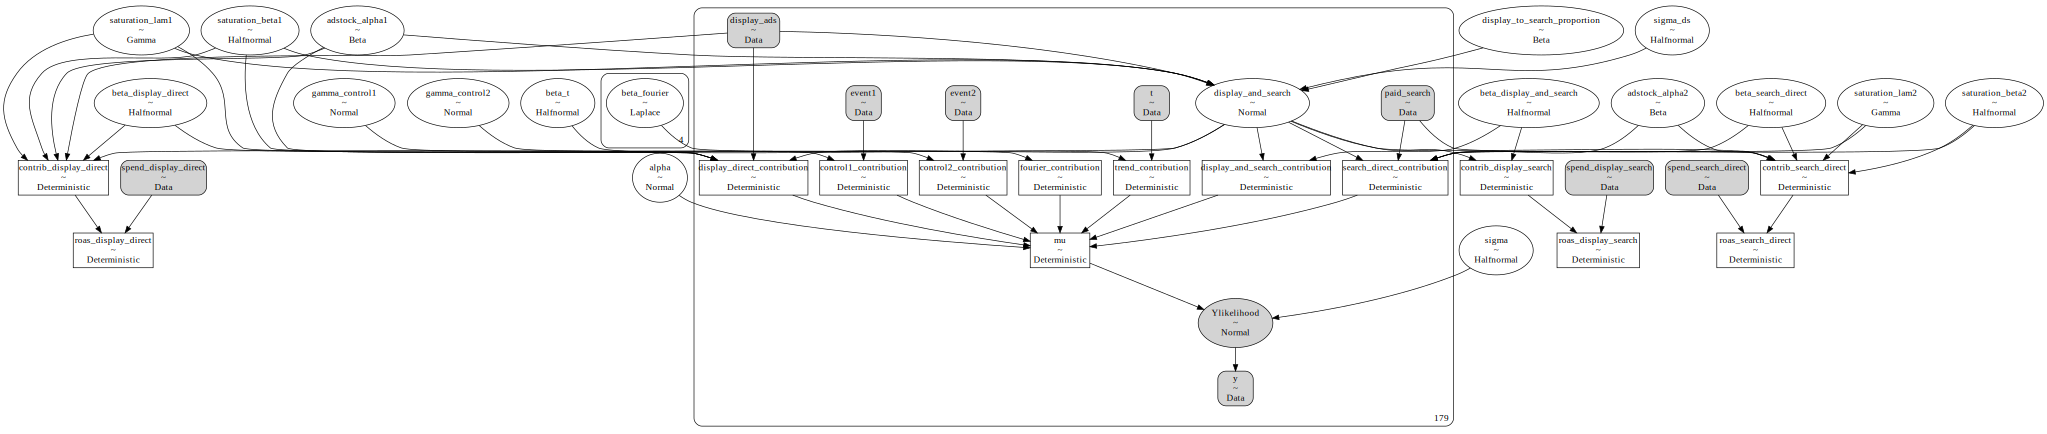

In [ ]:
pm.model_to_graphviz(model)

There's some divergences even though we fit the model a while.

In [ ]:
idata['sample_stats']['diverging'].sum().item()

875

Let's look at our predictions vs. actuals.

Shape of y_posterior before squeeze: (4, 2000, 179)
Shape of y_posterior after squeeze: (4, 2000, 179)


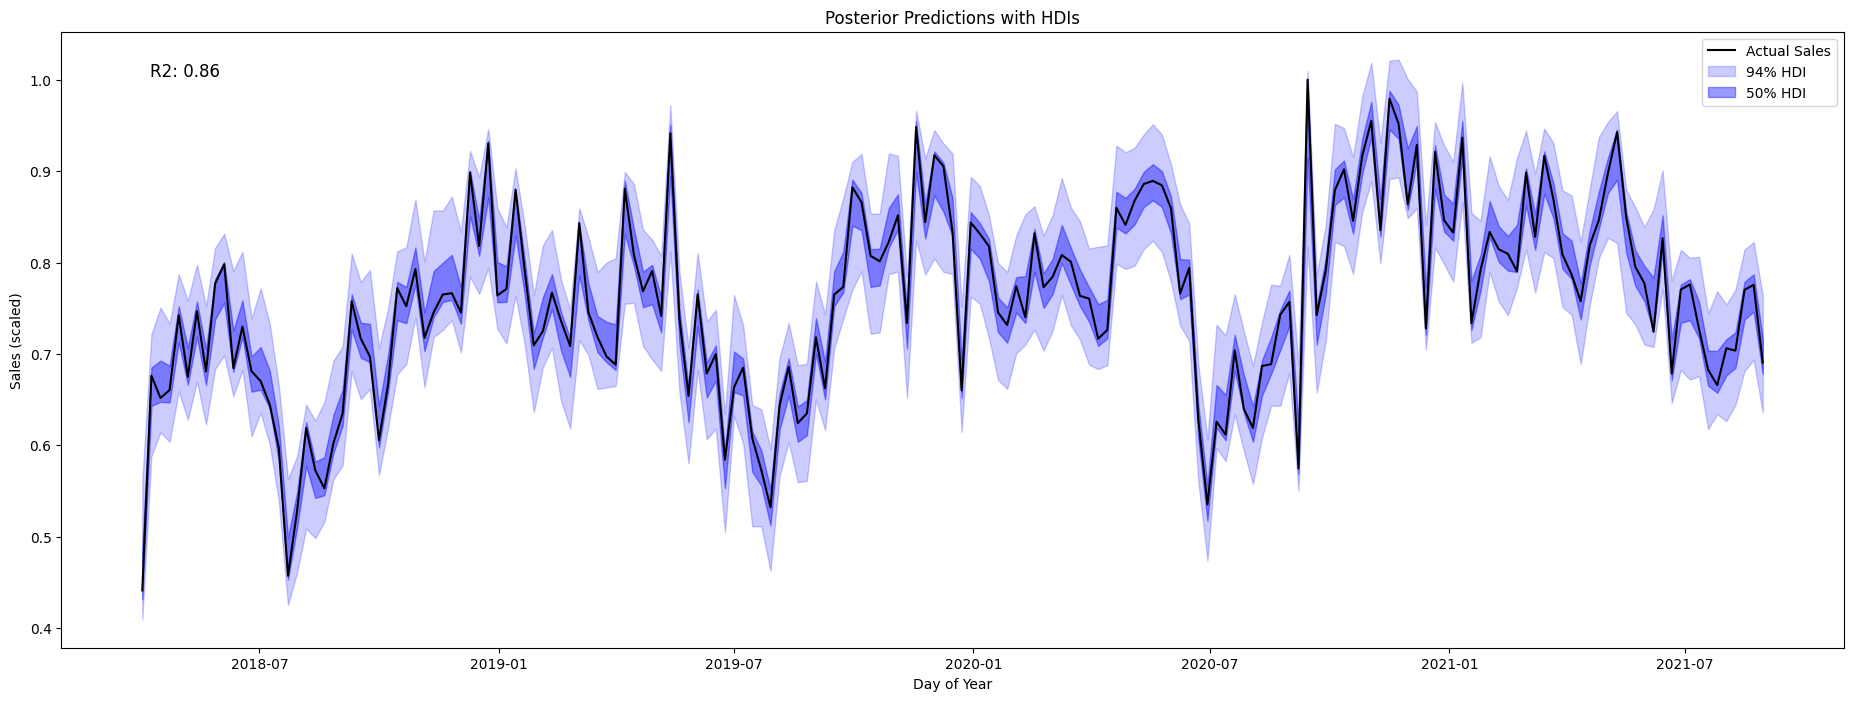

In [ ]:
# Extract predictions
y_posterior = idata.posterior_predictive["Ylikelihood"].values
print(f"Shape of y_posterior before squeeze: {y_posterior.shape}")

# Remove the extra dimension of size 1
y_posterior_squeezed = np.squeeze(y_posterior)
print(f"Shape of y_posterior after squeeze: {y_posterior_squeezed.shape}")

hdi_94 = az.hdi(y_posterior_squeezed, hdi_prob=0.94)
hdi_50 = az.hdi(y_posterior_squeezed, hdi_prob=0.50)
r2 = az.r2_score(
    y_true=scaled_data["y"].values,
    y_pred=idata.posterior_predictive.stack(sample=("chain", "draw"))[
        "Ylikelihood"
    ].values.T,
).iloc[0]

# Plot
plt.figure(figsize=(23, 8))
plt.plot(scaled_data['date_week'].values, scaled_data['y'], color="black", label="Actual Sales")
plt.fill_between(scaled_data['date_week'].values, hdi_94[:, 0], hdi_94[:, 1], color="blue", alpha=0.2, label="94% HDI")
plt.fill_between(scaled_data['date_week'].values, hdi_50[:, 0], hdi_50[:, 1], color="blue", alpha=0.4, label="50% HDI")
plt.title("Posterior Predictions with HDIs")
plt.xlabel("Day of Year")
plt.ylabel("Sales (scaled)")
plt.text(
    0.05,
    0.95,
    f"R2: {r2:.2f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment="top",
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="none"),
)
plt.legend()
plt.show()

Fit was decent with an $R^2$ of 0.86.

## Model Parameter Recovery

Let's see if we recovered the model parameters.

In [ ]:
from typing import Any

def plot_channel_parameter(idata, param_name: str, **plt_kwargs: Any) -> plt.Figure:
    """Plot the posterior distribution of a specific parameter for each channel.

    Parameters
    ----------
    idata : az.InferenceData
        The inference data containing the posterior samples.
    channel_columns : list[str]
        A list of strings representing the names of the media channels.
    param_name : str
        The name of the parameter to plot.
    **plt_kwargs : Any
        Additional keyword arguments to pass to the `plt.subplots` function.

    Returns
    -------
    plt.Figure
        The matplotlib Figure object containing the plot.

    Raises
    ------
    ValueError
        If the specified parameter name is invalid or not found in the inference data.

    """
    if param_name not in idata.posterior.data_vars:
        raise ValueError(
            f"Invalid parameter name: {param_name}. Choose from {list(idata.posterior.data_vars)}"
        )

    param_samples_df = pd.DataFrame(
        data=az.extract(data=idata, var_names=[param_name]).T,
    )

    fig, ax = plt.subplots(**plt_kwargs)
    sns.violinplot(data=param_samples_df, orient="h", ax=ax)
    ax.set(
        title=f"Posterior Distribution: {param_name} Parameter",
        xlabel=param_name,
        ylabel="channel",
    )
    return fig

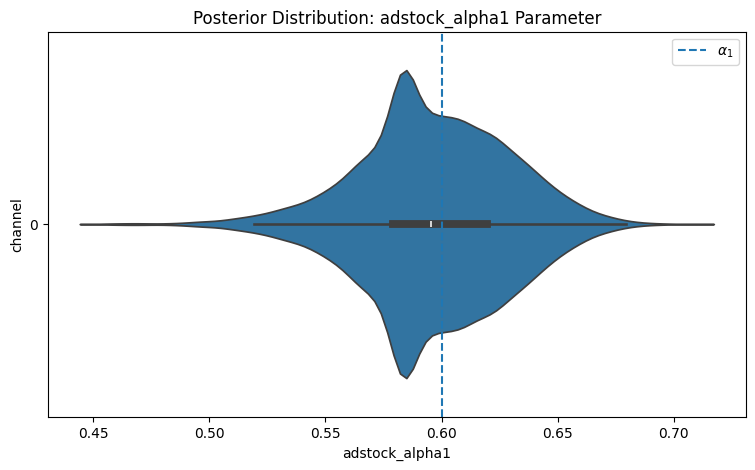

In [ ]:
fig = plot_channel_parameter(idata, param_name="adstock_alpha1", figsize=(9, 5))
ax = fig.axes[0]
ax.axvline(x=alpha1, color="C0", linestyle="--", label=r"$\alpha_1$")
ax.legend(loc="upper right");

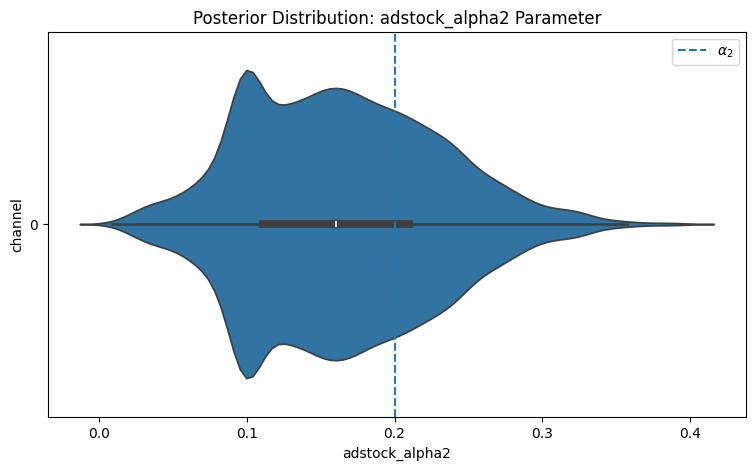

In [ ]:
fig = plot_channel_parameter(idata, param_name="adstock_alpha2", figsize=(9, 5))
ax = fig.axes[0]
ax.axvline(x=alpha2, color="C0", linestyle="--", label=r"$\alpha_2$")
ax.legend(loc="upper right");

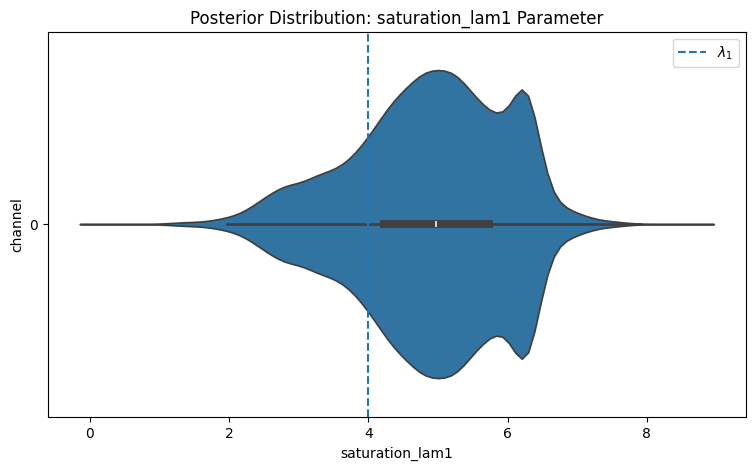

In [ ]:
fig = plot_channel_parameter(idata, param_name="saturation_lam1", figsize=(9, 5))
ax = fig.axes[0]
ax.axvline(x=lam1, color="C0", linestyle="--", label=r"$\lambda_1$")
ax.legend(loc="upper right");

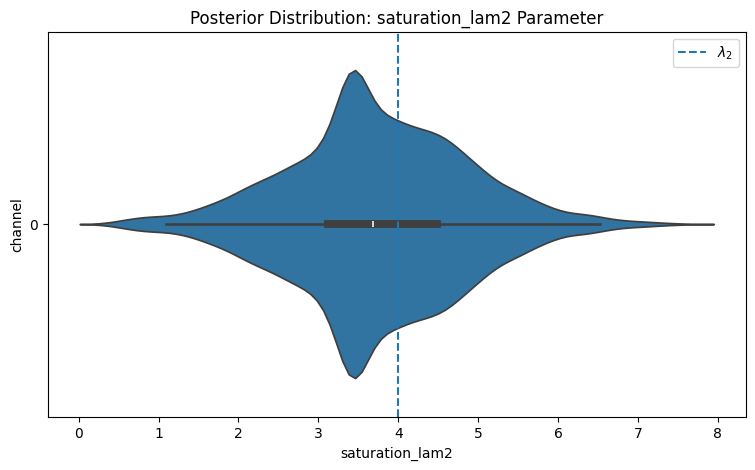

In [ ]:
fig = plot_channel_parameter(idata, param_name="saturation_lam2", figsize=(9, 5))
ax = fig.axes[0]
ax.axvline(x=lam2, color="C0", linestyle="--", label=r"$\lambda_2$")
ax.legend(loc="upper right");

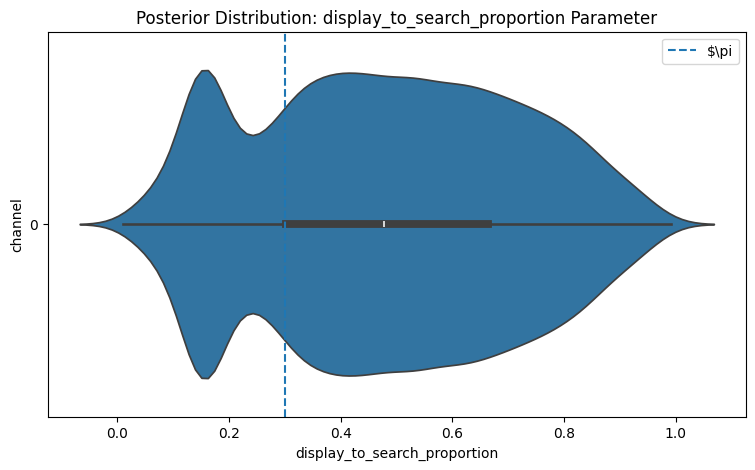

In [ ]:
fig = plot_channel_parameter(idata, param_name="display_to_search_proportion", figsize=(9, 5))
ax = fig.axes[0]
ax.axvline(x=proportion_display_to_search, color="C0", linestyle="--", label=r"$\pi")
ax.legend(loc="upper right");

Looks like the model had a hard time recovering the right proportion (0.3).

## Contribution Recovery

Great, how about contributions parameters?

In [ ]:
flat = idata["posterior"]["display_direct_contribution"].data.flatten()
channel1_orig = flat*scaler.max_abs_[0]
channel1_orig = channel1_orig.reshape(idata["posterior"]["display_direct_contribution"].shape)

In [ ]:
flat = idata["posterior"]["display_and_search_contribution"].data.flatten()
channel2_orig = flat*scaler.max_abs_[0]
channel2_orig = channel2_orig.reshape(idata["posterior"]["display_and_search_contribution"].shape)


In [ ]:
flat = idata["posterior"]["search_direct_contribution"].data.flatten()
channel3_orig = flat*scaler.max_abs_[0]
channel3_orig = channel3_orig.reshape(idata["posterior"]["search_direct_contribution"].shape)

In [ ]:
# sum over date axis (axis=2), producing (chain, draw)
ch1 = xr.DataArray(channel1_orig.sum(axis=2), dims=["chain", "draw"])
ch2 = xr.DataArray(channel2_orig.sum(axis=2), dims=["chain", "draw"])
ch3 = xr.DataArray(channel3_orig.sum(axis=2), dims=["chain", "draw"])

# get total contribution
total_contribution = ch1 + ch2 + ch3

In [ ]:
ch1_share = ch1 / total_contribution
ch2_share = ch2 / total_contribution
ch3_share = ch3 / total_contribution

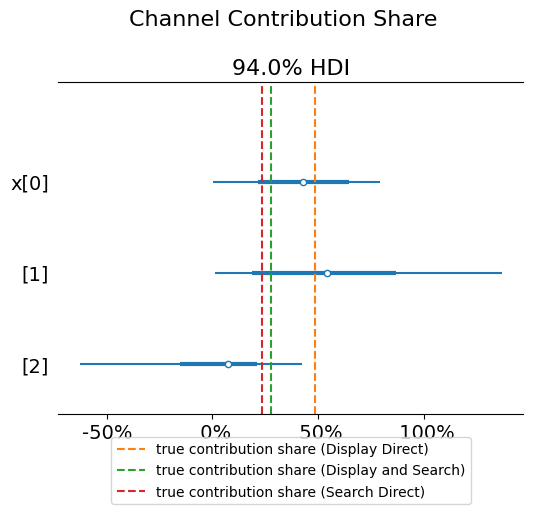

In [ ]:
import matplotlib.ticker as mtick

# stack chain and draw into one dimension
channel_contrib = xr.concat([ch1_share, ch2_share, ch3_share], dim="channel")

ax, *_ = az.plot_forest(channel_contrib, combined=True, hdi_prob=.94)
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f"{y: 0.0%}"))
fig: plt.Figure = plt.gcf()
fig.suptitle("Channel Contribution Share", fontsize=16, y=1.05)
ax = fig.axes[0]
ax.axvline(
    x=contribution_share_display_ads,
    color="C1",
    linestyle="--",
    label="true contribution share (Display Direct)",
)
ax.axvline(
    x=contribution_share_display_search,
    color="C2",
    linestyle="--",
    label="true contribution share (Display and Search)",
)
ax.axvline(
    x=contribution_share_paid_search,
    color="C3",
    linestyle="--",
    label="true contribution share (Search Direct)",
)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=1);

## ROAS recovery

In [ ]:
scaler.max_abs_[0]

np.float64(7.090278186430725)

Text(0.5, 1.06, 'ROAS Posterior Distributions')

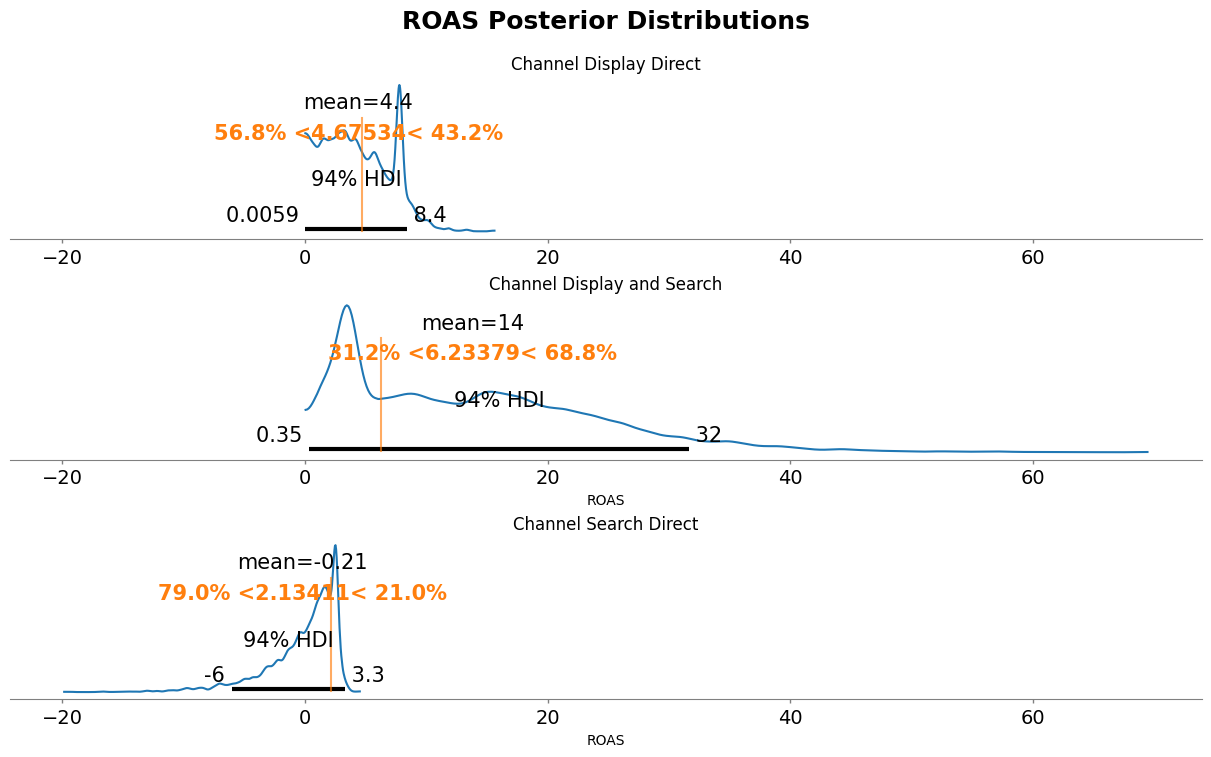

In [ ]:
# sum over date axis (axis=2), producing (chain, draw)
roas_ch1 = xr.DataArray(channel1_orig.sum(axis=2), dims=["chain", "draw"])
roas_ch2 = xr.DataArray(channel2_orig.sum(axis=2), dims=["chain", "draw"])
roas_ch3 = xr.DataArray(channel3_orig.sum(axis=2), dims=["chain", "draw"])

# divide by total spend
roas_ch1 = roas_ch1 / (df["display_ads"].sum()*(1-proportion_display_to_search))
roas_ch2 = roas_ch2 / (df["display_ads"].sum()*(proportion_display_to_search))
roas_ch3 = roas_ch3 / (df['paid_search'].sum())

# stack into one DataArray with "channel" dimension so arviz plots nicely
roas_samples = xr.concat(
    [roas_ch1, roas_ch2, roas_ch3],
    dim=xr.IndexVariable("channel", ["display_direct", "display_search", "search_direct"]))


# plot
fig, axes = plt.subplots(
    nrows=3, ncols=1, figsize=(12, 7), sharex=True, sharey=False, layout="constrained"
)
az.plot_posterior(
    roas_samples,
    ref_val=[roas_1_actual, roas_2_actual, roas_3_actual],  # your benchmark ROAS
    ax=axes,
)
axes[0].set(title="Channel Display Direct")
axes[1].set(title="Channel Display and Search", xlabel="ROAS")
axes[2].set(title="Channel Search Direct", xlabel="ROAS")
fig.suptitle("ROAS Posterior Distributions", fontsize=18, fontweight="bold", y=1.06)

Display was about right, display and search had a wide range, and search was pretty off.

# Compare to Naive Baseline Model

Our original causal model might be too complex. Will the naive model perform better?

In [ ]:
import pymc as pm

with pm.Model() as bm:
    # ----------------------
    # Data
    # ----------------------
    display_ads = pm.Data("display_ads", scaled_data["display_ads"].values)
    paid_search = pm.Data("paid_search", scaled_data["paid_search"].values)
    t = pm.Data('t', scaled_data["t"].values)
    event_1 = pm.Data('event1', scaled_data["event_1"].values)
    event_2 = pm.Data('event2', scaled_data["event_2"].values)
    y = pm.Data('y', scaled_data['y'].values)
    # ----------------------
    # Priors
    # ----------------------
    alpha = pm.Normal("alpha", 0.5, sigma=0.2)          # intercept
    beta_t = pm.HalfNormal("beta_t", sigma=0.1)        # trend slope

    # Media spend coefficients
    beta_display = pm.HalfNormal("beta_display", sigma=0.5)
    beta_search = pm.HalfNormal("beta_search", sigma=0.5)

    # Fourier terms
    beta_fourier = pm.Laplace("beta_fourier", mu=0.0, b=0.2, shape=fourier_terms.shape[1])

    # Control events
    gamma_control1 = pm.Normal("gamma_control1", 0, 0.05)
    gamma_control2 = pm.Normal("gamma_control2", 0, 0.05)

    # Noise
    sigma = pm.HalfNormal("sigma", sigma=2)

    # Adstock and saturation priors
    adstock_alpha1 = pm.Beta("adstock_alpha1", alpha=2, beta=2)
    saturation_lam1 = pm.Gamma("saturation_lam1", alpha=3, beta=1)
    saturation_beta1 = pm.HalfNormal("saturation_beta1", sigma=2)

    adstock_alpha2 = pm.Beta("adstock_alpha2", alpha=2, beta=2)
    saturation_lam2 = pm.Gamma("saturation_lam2", alpha=3, beta=1)
    saturation_beta2 = pm.HalfNormal("saturation_beta2", sigma=2)

    # ----------------------
    # Forward pass and Deterministic contributions
    # ----------------------
    display_transformed = forward_pass(display_ads,  adstock_alpha1, saturation_lam1, saturation_beta1)
    search_transformed = forward_pass(paid_search, adstock_alpha2, saturation_lam2, saturation_beta2)

    display_contribution = pm.Deterministic("display_contribution", beta_display * display_transformed)
    search_contribution = pm.Deterministic("search_contribution", beta_search * search_transformed)
    fourier_contribution = pm.Deterministic("fourier_contribution", pm.math.dot(fourier_terms, beta_fourier))
    trend_contribution = pm.Deterministic("trend_contribution", beta_t * t)
    control1_contribution = pm.Deterministic("control1_contribution", gamma_control1 * event_1)
    control2_contribution = pm.Deterministic("control2_contribution", gamma_control2 * event_2)
    spend_display = pm.Data("spend_display_direct", df["display_ads"].sum())
    spend_search = pm.Data("spend_search_direct", df["paid_search"].sum())

    contrib_display = pm.Deterministic("contrib_display", beta_display_direct * display_direct.sum())
    contrib_search = pm.Deterministic("contrib_search", beta_search_direct * search_direct.sum())

    roas_1 = pm.Deterministic("roas_display", contrib_display / spend_display)
    roas_2 = pm.Deterministic("roas_search", contrib_search / spend_search)

    # ----------------------
    # Expected value of outcome
    # ----------------------
    mu = pm.Deterministic(
        "mu",
        alpha
        + display_contribution
        + search_contribution
        + fourier_contribution
        + trend_contribution
        + control1_contribution
        + control2_contribution
    )

    # Likelihood
    Ylikelihood = pm.Normal("Ylikelihood", mu, sigma, observed=y)

    # Prior predictive check
    bm_idata = pm.sample_prior_predictive(samples=500, random_seed=rng)


Check if our priors are good.

Shape of y_prior before squeeze: (1, 500, 179)
Shape of y_prior after squeeze: (500, 179)


/tmp/ipython-input-2965477908.py:9: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_94 = az.hdi(y_prior_squeezed, hdi_prob=0.94)
/tmp/ipython-input-2965477908.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_50 = az.hdi(y_prior_squeezed, hdi_prob=0.50)


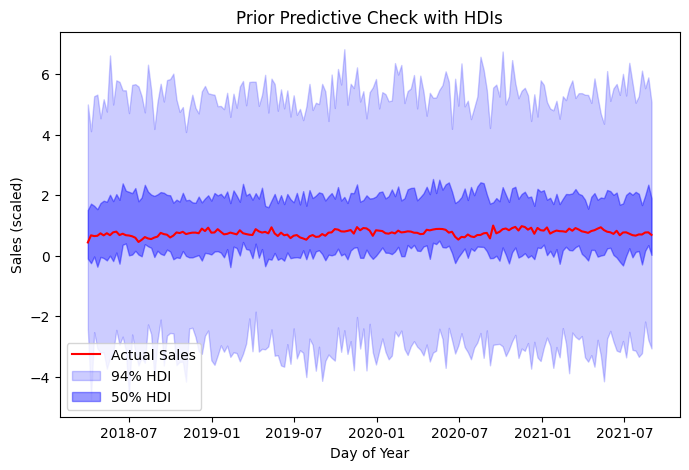

In [ ]:
# Extract predictions
y_prior = bm_idata.prior_predictive["Ylikelihood"].values
print(f"Shape of y_prior before squeeze: {y_prior.shape}")

# Remove the extra dimension of size 1
y_prior_squeezed = np.squeeze(y_prior)
print(f"Shape of y_prior after squeeze: {y_prior_squeezed.shape}")

hdi_94 = az.hdi(y_prior_squeezed, hdi_prob=0.94)
hdi_50 = az.hdi(y_prior_squeezed, hdi_prob=0.50)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(scaled_data['date_week'].values, scaled_data['y'], color="red", label="Actual Sales")
plt.fill_between(scaled_data['date_week'].values, hdi_94[:, 0], hdi_94[:, 1], color="blue", alpha=0.2, label="94% HDI")
plt.fill_between(scaled_data['date_week'].values, hdi_50[:, 0], hdi_50[:, 1], color="blue", alpha=0.4, label="50% HDI")
plt.title("Prior Predictive Check with HDIs")
plt.xlabel("Day of Year")
plt.ylabel("Sales (scaled)")
plt.legend()
plt.show()

## Model Diagnostics

Output()

ERROR:pymc.stats.convergence:There were 124 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/usr/local/lib/python3.12/dist-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (32), generating only 20 plots
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/usr/local/lib/python3.12/dist-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite valu

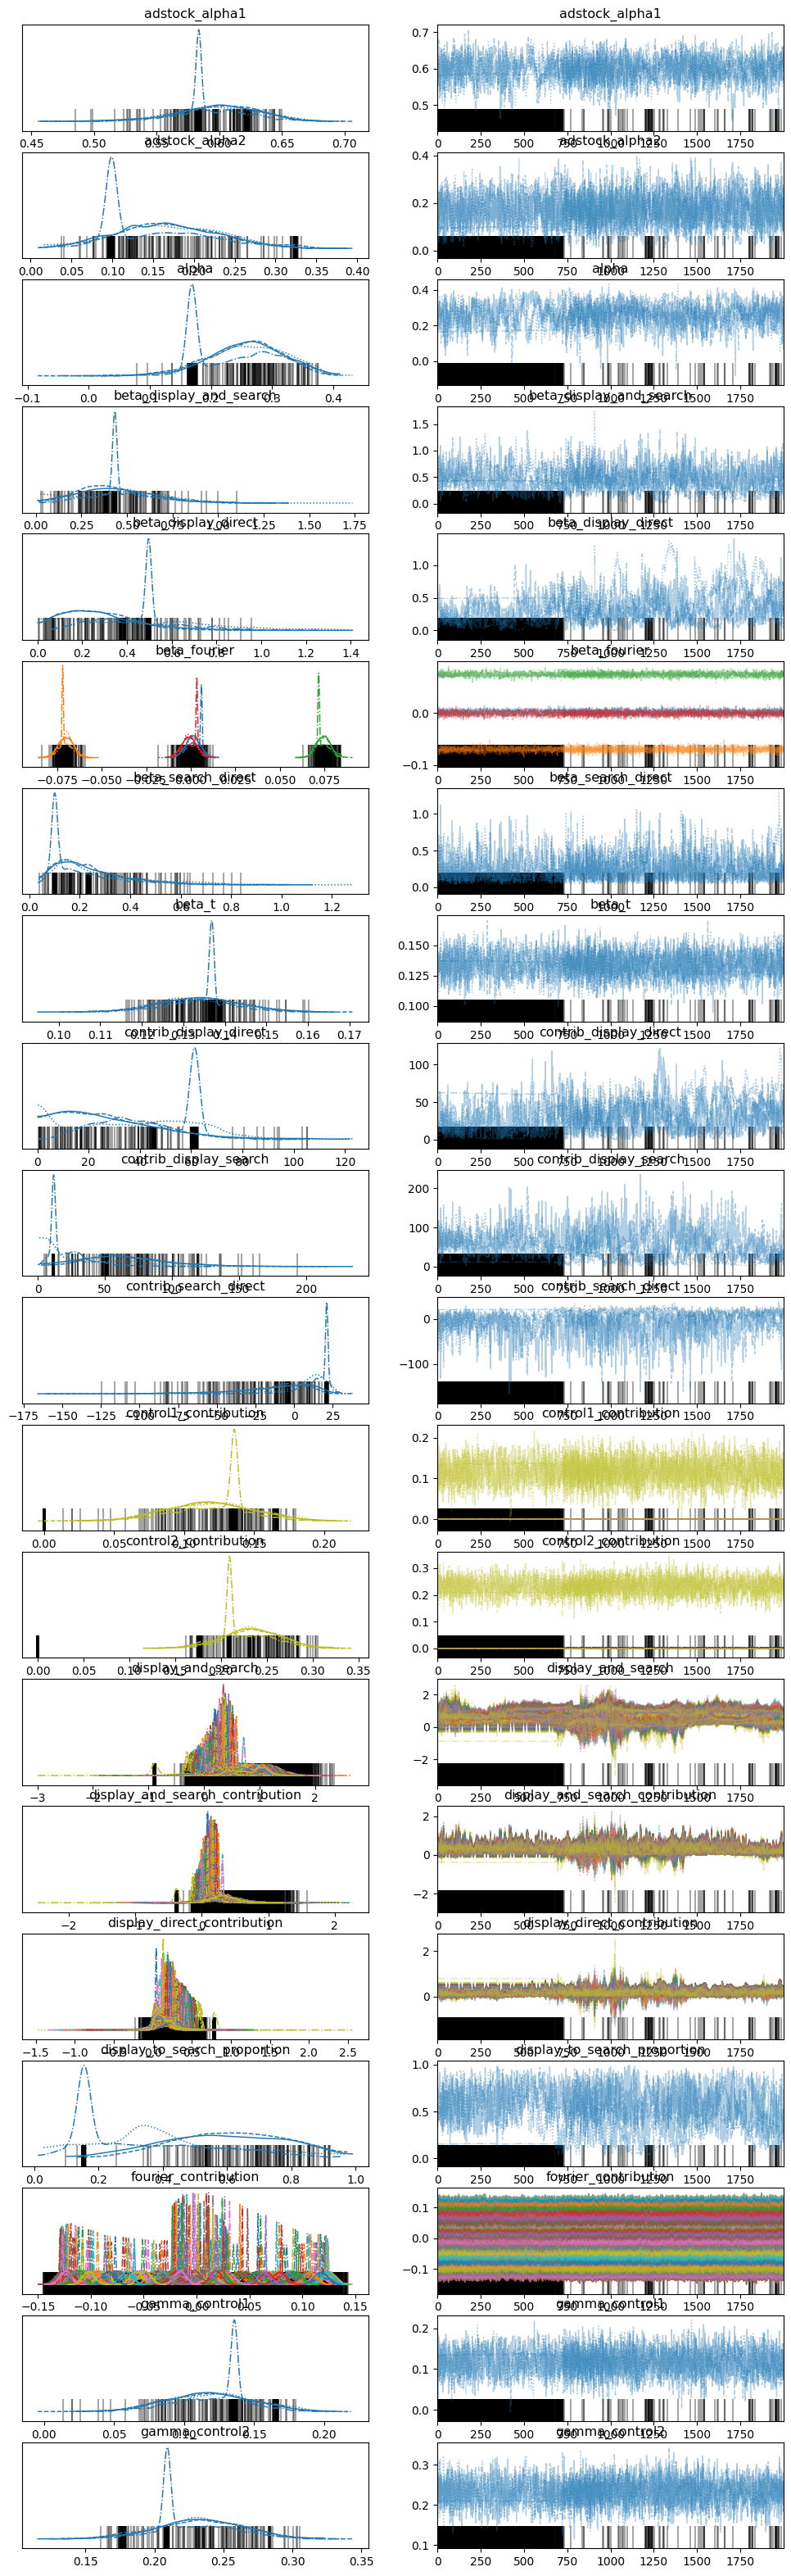

In [ ]:
with bm:
    bm_idata.extend(pm.sample(1000, tune=1000, random_seed=rng))

az.plot_trace(idata);

In [ ]:
with bm:
    pm.sample_posterior_predictive(bm_idata, extend_inferencedata=True, random_seed=rng)

Output()

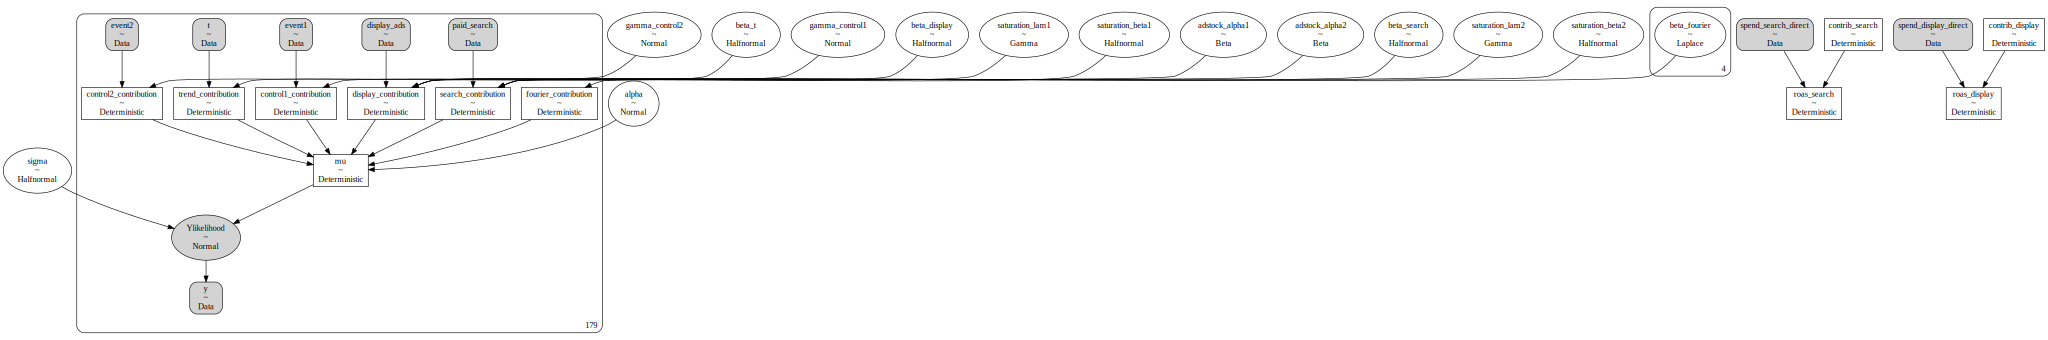

In [ ]:
pm.model_to_graphviz(bm)

In [ ]:
bm_idata['sample_stats']['diverging'].sum().item()

124

Shape of y_posterior before squeeze: (2, 1000, 179)
Shape of y_posterior after squeeze: (2, 1000, 179)


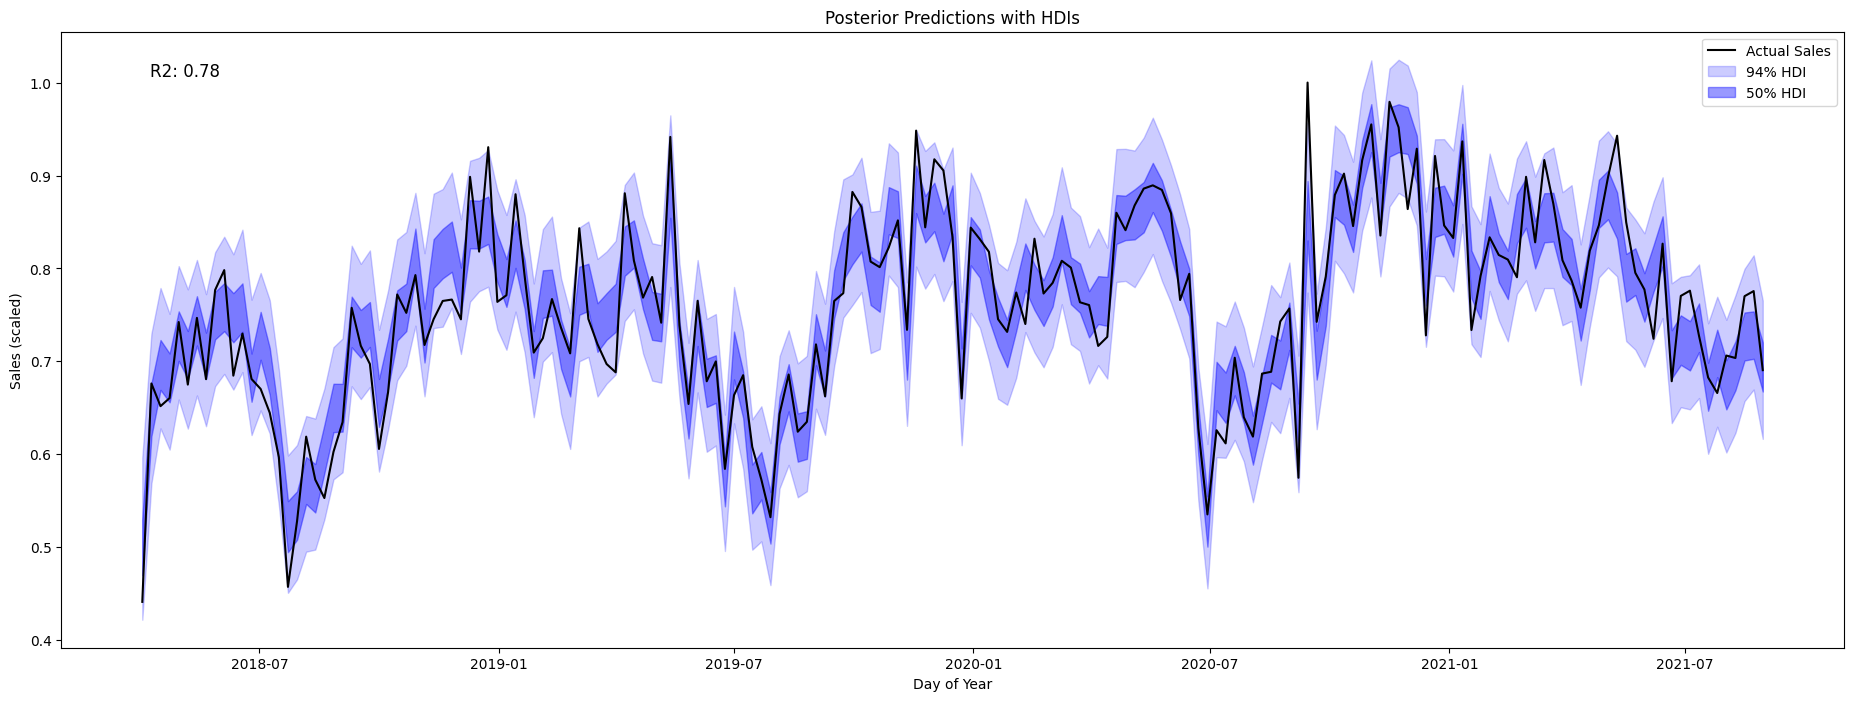

In [ ]:
# Extract predictions
y_posterior = bm_idata.posterior_predictive["Ylikelihood"].values
print(f"Shape of y_posterior before squeeze: {y_posterior.shape}")

# Remove the extra dimension of size 1
y_posterior_squeezed = np.squeeze(y_posterior)
print(f"Shape of y_posterior after squeeze: {y_posterior_squeezed.shape}")

hdi_94 = az.hdi(y_posterior_squeezed, hdi_prob=0.94)
hdi_50 = az.hdi(y_posterior_squeezed, hdi_prob=0.50)
r2 = az.r2_score(
    y_true=scaled_data["y"].values,
    y_pred=bm_idata.posterior_predictive.stack(sample=("chain", "draw"))[
        "Ylikelihood"
    ].values.T,
).iloc[0]

# Plot
plt.figure(figsize=(23, 8))
plt.plot(scaled_data['date_week'].values, scaled_data['y'], color="black", label="Actual Sales")
plt.fill_between(scaled_data['date_week'].values, hdi_94[:, 0], hdi_94[:, 1], color="blue", alpha=0.2, label="94% HDI")
plt.fill_between(scaled_data['date_week'].values, hdi_50[:, 0], hdi_50[:, 1], color="blue", alpha=0.4, label="50% HDI")
plt.title("Posterior Predictions with HDIs")
plt.xlabel("Day of Year")
plt.ylabel("Sales (scaled)")
plt.text(
    0.05,
    0.95,
    f"R2: {r2:.2f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment="top",
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="none"),
)
plt.legend()
plt.show()

Fit was worse than the causal model. Let's see if the parameters are better or not.

## Model Parameter Recovery

Let's see if we recovered the model parameters.

In [ ]:
from typing import Any

def plot_channel_parameter(idata, param_name: str, **plt_kwargs: Any) -> plt.Figure:
    """Plot the posterior distribution of a specific parameter for each channel.

    Parameters
    ----------
    idata : az.InferenceData
        The inference data containing the posterior samples.
    channel_columns : list[str]
        A list of strings representing the names of the media channels.
    param_name : str
        The name of the parameter to plot.
    **plt_kwargs : Any
        Additional keyword arguments to pass to the `plt.subplots` function.

    Returns
    -------
    plt.Figure
        The matplotlib Figure object containing the plot.

    Raises
    ------
    ValueError
        If the specified parameter name is invalid or not found in the inference data.

    """
    if param_name not in idata.posterior.data_vars:
        raise ValueError(
            f"Invalid parameter name: {param_name}. Choose from {list(idata.posterior.data_vars)}"
        )

    param_samples_df = pd.DataFrame(
        data=az.extract(data=idata, var_names=[param_name]).T,
    )

    fig, ax = plt.subplots(**plt_kwargs)
    sns.violinplot(data=param_samples_df, orient="h", ax=ax)
    ax.set(
        title=f"Posterior Distribution: {param_name} Parameter",
        xlabel=param_name,
        ylabel="channel",
    )
    return fig

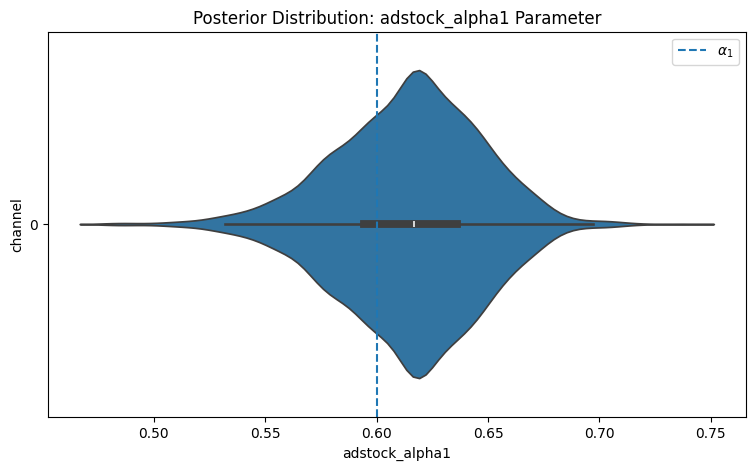

In [ ]:
fig = plot_channel_parameter(bm_idata, param_name="adstock_alpha1", figsize=(9, 5))
ax = fig.axes[0]
ax.axvline(x=alpha1, color="C0", linestyle="--", label=r"$\alpha_1$")
ax.legend(loc="upper right");

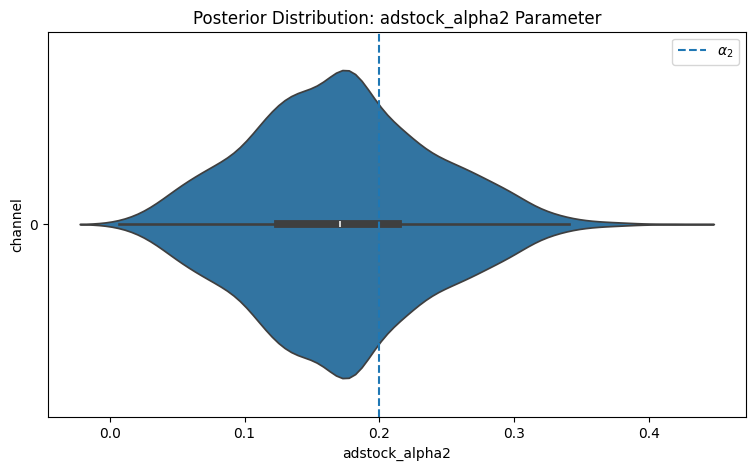

In [ ]:
fig = plot_channel_parameter(bm_idata, param_name="adstock_alpha2", figsize=(9, 5))
ax = fig.axes[0]
ax.axvline(x=alpha2, color="C0", linestyle="--", label=r"$\alpha_2$")
ax.legend(loc="upper right");

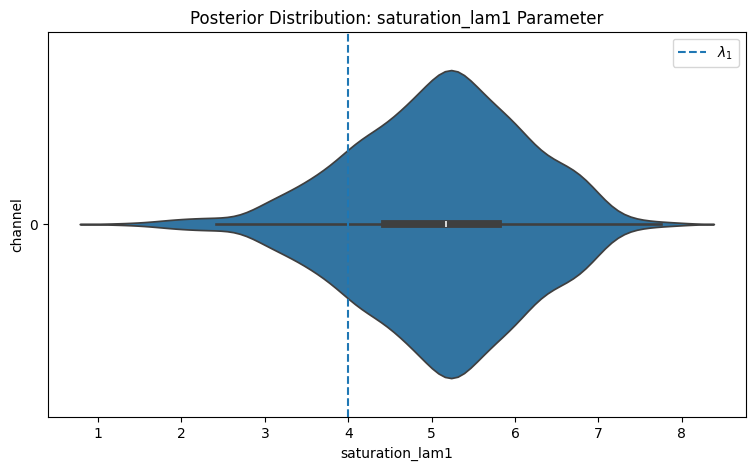

In [ ]:
fig = plot_channel_parameter(bm_idata, param_name="saturation_lam1", figsize=(9, 5))
ax = fig.axes[0]
ax.axvline(x=lam1, color="C0", linestyle="--", label=r"$\lambda_1$")
ax.legend(loc="upper right");

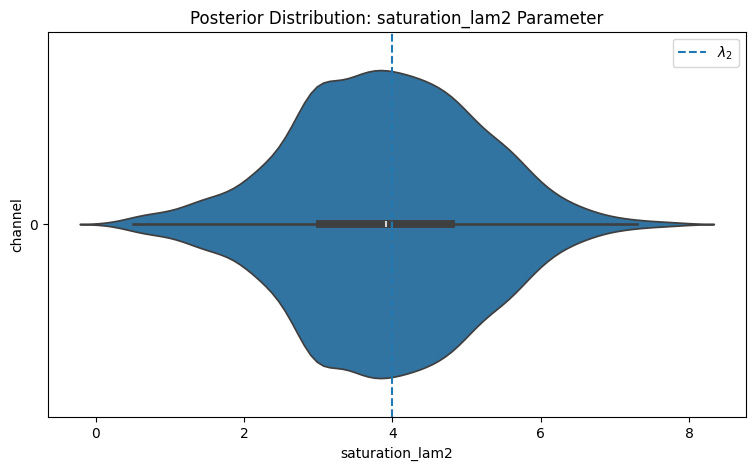

In [ ]:
fig = plot_channel_parameter(bm_idata, param_name="saturation_lam2", figsize=(9, 5))
ax = fig.axes[0]
ax.axvline(x=lam2, color="C0", linestyle="--", label=r"$\lambda_2$")
ax.legend(loc="upper right");

## Contribution Recovery

Great, how about contributions parameters?

In [ ]:
flat = bm_idata["posterior"]["display_contribution"].data.flatten()
channel1_orig = flat*scaler.max_abs_[0]
channel1_orig = channel1_orig.reshape(bm_idata["posterior"]["display_contribution"].shape)

In [ ]:
flat = bm_idata["posterior"]["search_contribution"].data.flatten()
channel2_orig = flat*scaler.max_abs_[0]
channel2_orig = channel2_orig.reshape(bm_idata["posterior"]["search_contribution"].shape)


In [ ]:
# sum over date axis (axis=2), producing (chain, draw)
ch1 = xr.DataArray(channel1_orig.sum(axis=2), dims=["chain", "draw"])
ch2 = xr.DataArray(channel2_orig.sum(axis=2), dims=["chain", "draw"])

# get total contribution
total_contribution = ch1 + ch2

In [ ]:
ch1_share = ch1 / total_contribution
ch2_share = ch2 / total_contribution

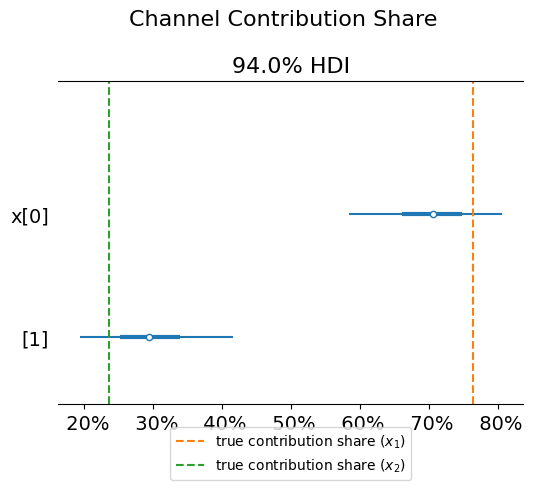

In [ ]:
import matplotlib.ticker as mtick

# stack chain and draw into one dimension
channel_contrib = xr.concat([ch1_share, ch2_share], dim="channel")

ax, *_ = az.plot_forest(channel_contrib, combined=True, hdi_prob=.94)
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f"{y: 0.0%}"))
fig: plt.Figure = plt.gcf()
fig.suptitle("Channel Contribution Share", fontsize=16, y=1.05)
ax = fig.axes[0]
ax.axvline(
    x=contribution_share_display_total,
    color="C1",
    linestyle="--",
    label="true contribution share ($x_1$)",
)
ax.axvline(
    x=contribution_share_paid_search,
    color="C2",
    linestyle="--",
    label="true contribution share ($x_2$)",
)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=1);

Looks like it underestimated display and overestimated search. That makes sense. We know that display is actually stronger because it helped influence search. This leads me to believe that lower funnel channels generally will be overestimated in naive MMM models.

## ROAS recovery

In [ ]:
scaler.max_abs_[0]

np.float64(7.090278186430725)

Text(0.5, 1.06, 'ROAS Posterior Distributions')

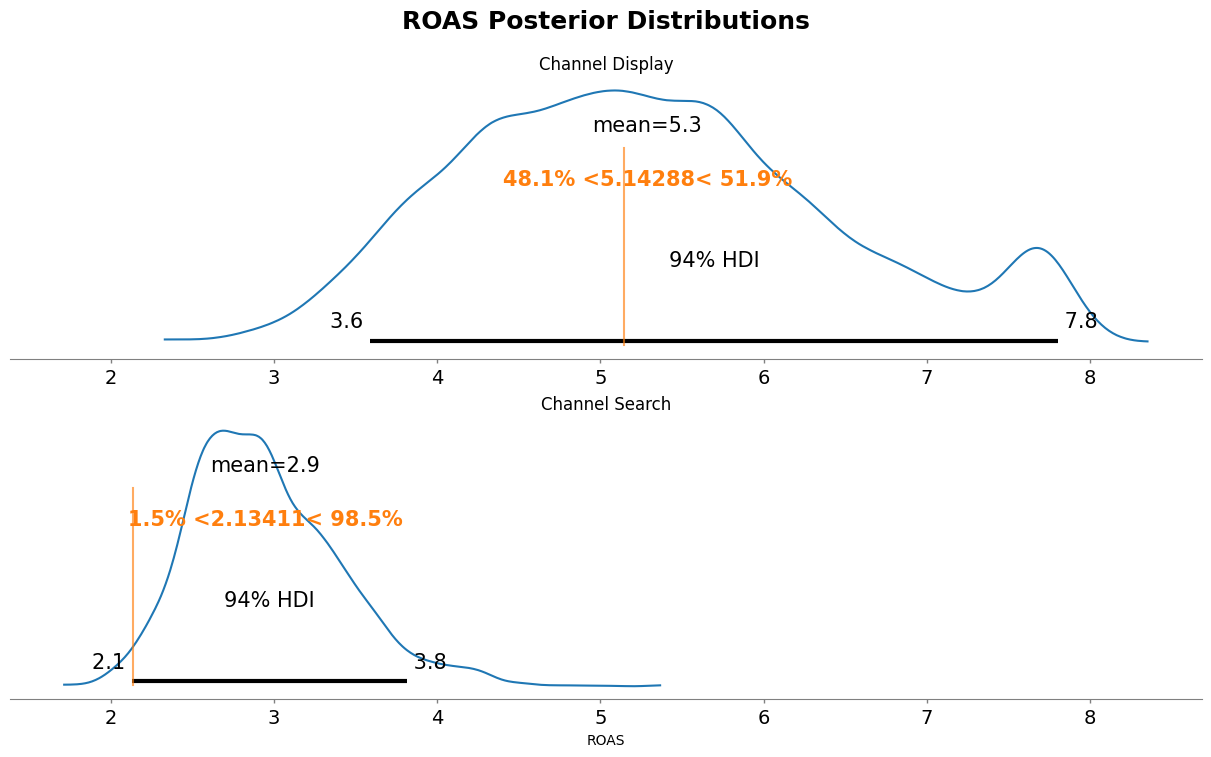

In [ ]:
# sum over date axis (axis=2), producing (chain, draw)
roas_ch1 = xr.DataArray(channel1_orig.sum(axis=2), dims=["chain", "draw"])
roas_ch2 = xr.DataArray(channel2_orig.sum(axis=2), dims=["chain", "draw"])

# divide by total spend
spend_sum = data[["display_ads", "paid_search"]].sum().to_numpy()
roas_ch1 = roas_ch1 / spend_sum[0]
roas_ch2 = roas_ch2 / spend_sum[1]

roas_samples = xr.concat(
    [roas_ch1, roas_ch2],
    dim=xr.IndexVariable("channel", ["display", "search"]))

# plot
fig, axes = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 7), sharex=True, sharey=False, layout="constrained"
)
az.plot_posterior(
    roas_samples,
    ref_val=[roas_display_total, roas_3_actual],  # your benchmark ROAS
    ax=axes,
)
axes[0].set(title="Channel Display")
axes[1].set(title="Channel Search", xlabel="ROAS")
fig.suptitle("ROAS Posterior Distributions", fontsize=18, fontweight="bold", y=1.06)

Ultimately, it got display's ROAS about right, but overestimated search's ROAS.

# Conclusion

Based on these results, it looks like our data wasn't powerful enough to help the causal model figure out the true proportion.

I would prefer the simpler model, because it recovered the ROAS parameters better than the more complex causal model.

A key learning is that paid search was overestimated in the naive model. This leads to a new hypothesis. Do naive MMMs typically overestimate lower funnel channels?

Next steps:

1. see if adding a more accurate prior thanks to a lift study would help correct the naive model.
2. try to improve the causal model by simplifying it a bit.